In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [19]:
alpha = pd.read_csv("alpha.csv")
beta = pd.read_csv("beta.csv")
charlie = pd.read_csv("charlie.csv")

alpha = alpha.sample(frac=1).reset_index(drop=True)
beta = beta.sample(frac=1).reset_index(drop=True)
charlie = charlie.sample(frac=1).reset_index(drop=True)


data = alpha.copy()#.append(beta).append(charlie).reset_index(drop=True)

In [20]:
data = data.drop(columns=["created_at","MG811_Digital","MQ7_Digital"])

# Drop rows where the value of 'column_name' is 0
#data = data.loc[data['CO'] != 0]


In [21]:
data.head()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2,CO
0,32.88,57.69,3283.0,2066.0,5417.0,3286.0,598.0,0.0
1,33.41,55.26,3086.0,1303.0,4953.0,2406.0,600.0,0.0
2,33.43,53.86,3590.0,1505.0,3705.0,2701.0,598.0,0.0
3,32.17,61.04,3185.0,1539.0,2835.0,1465.0,608.0,0.0
4,31.94,66.31,5318.0,3266.0,5058.0,2927.0,619.0,0.0


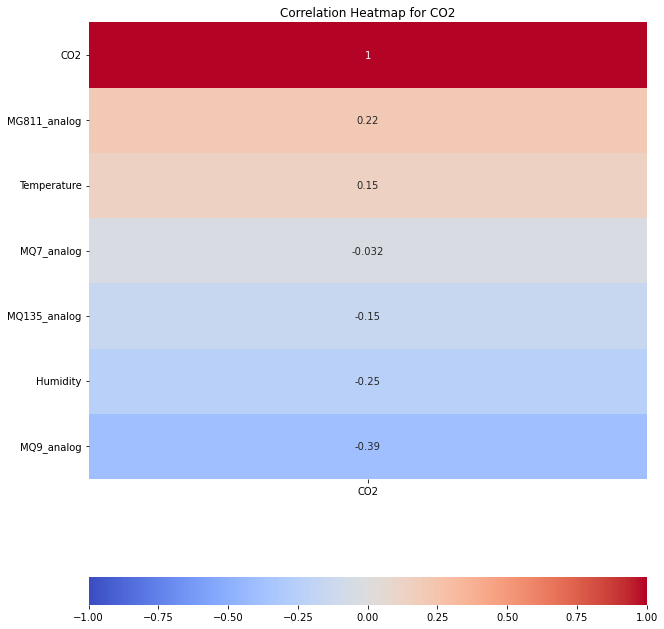

In [22]:
# Create a correlation matrix for the DataFrame
correlation_matrix = data.drop(columns=["CO"]).corr()

# Plot the correlation heatmap for the 'CO2' column
plt.figure(figsize=(10, 12))
sns.heatmap(correlation_matrix[['CO2']].sort_values(by='CO2', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1,cbar_kws={"orientation": "horizontal"})
plt.title('Correlation Heatmap for CO2')

# Save the plot as an image
plt.savefig('Alpha_co2_correlation_plot.png', bbox_inches='tight')

plt.show()

In [23]:
target = data.CO2
data = data.drop(["CO2", "CO"], axis = 1)

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,RobustScaler

# Assuming you have your dataframe 'df' with the features to be scaled

# Step 1: Create a MinMaxScaler object
scaler = MinMaxScaler()

# Step 2: Fit the scaler to the data and transform the data
scaled_data = scaler.fit_transform(data)

# Step 3: Convert the scaled data back to a dataframe (optional)
data = pd.DataFrame(scaled_data, columns=data.columns)


In [25]:
data.isnull().sum()

Temperature     0
Humidity        0
MQ7_analog      0
MQ9_analog      0
MG811_analog    0
MQ135_analog    0
dtype: int64

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2814 entries, 0 to 2813
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Temperature   2814 non-null   float64
 1   Humidity      2814 non-null   float64
 2   MQ7_analog    2814 non-null   float64
 3   MQ9_analog    2814 non-null   float64
 4   MG811_analog  2814 non-null   float64
 5   MQ135_analog  2814 non-null   float64
dtypes: float64(6)
memory usage: 132.0 KB


In [27]:
data.describe()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog
count,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000,2814.000000
mean,0.673036,0.423163,0.172882,0.163097,0.444873,0.307700
std,0.199415,0.215166,0.150728,0.143337,0.203104,0.164211
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.655949,0.267701,0.067141,0.059890,0.276793,0.199376
50%,0.686495,0.368934,0.132468,0.093848,0.466585,0.339002
75%,0.788987,0.583532,0.224770,0.254718,0.582585,0.395692
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Assuming you have the data loaded in 'data' and the labels in 'target'

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Step 2: Build regression models using k-fold cross-validation
models = {
    "LGBM": lgb.LGBMRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "CatBoost": cb.CatBoostRegressor(silent=True, n_estimators=100),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "Linear Regression": LinearRegression(),
    "MLP": MLPRegressor(hidden_layer_sizes=(100, 50, 10), max_iter=500, random_state=42)
}

eval_metrics = {
    "MAE": mean_absolute_error,
    "RMSE": lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    "R2": r2_score,
    "MSE": mean_squared_error
}

results = []

for model_name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    cv_mae = -cv_scores.mean()  # Since cross_val_score returns negative MAE

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_results = {"Model": model_name, "CrossVal MAE": cv_mae}

    for metric_name, metric_func in eval_metrics.items():
        metric_value = metric_func(y_test, y_pred)
        model_results[metric_name] = metric_value

    results.append(model_results)

# Step 3: Save the results in a DataFrame
results_df = pd.DataFrame(results)

results_df

,Model,CrossVal MAE,MAE,RMSE,R2,MSE
0,LGBM,2.755388,2.731859,4.257529,0.931856,18.126556
1,XGBoost,2.776941,2.805857,4.486544,0.924327,20.129075
2,CatBoost,2.937511,2.976621,4.243072,0.932318,18.003664
3,Random Forest,2.556771,2.598330,4.105631,0.936631,16.856207
4,Gradient Boosting,3.622022,3.808699,5.466767,0.887649,29.885539
5,SVR,8.449379,8.573931,11.912004,0.466561,141.895847
6,Linear Regression,11.559885,11.514112,14.385553,0.222020,206.944123
7,MLP,15.029258,11.712129,14.929288,0.162097,222.883646


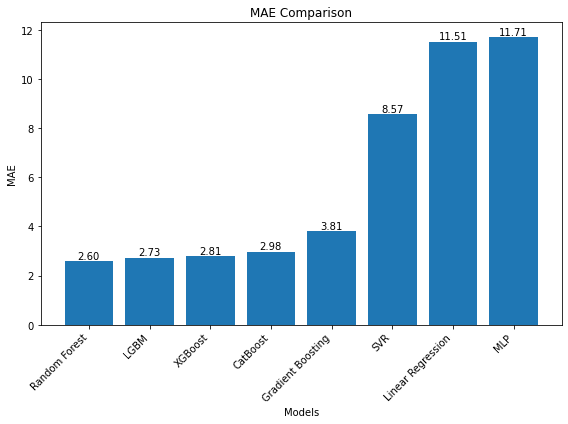

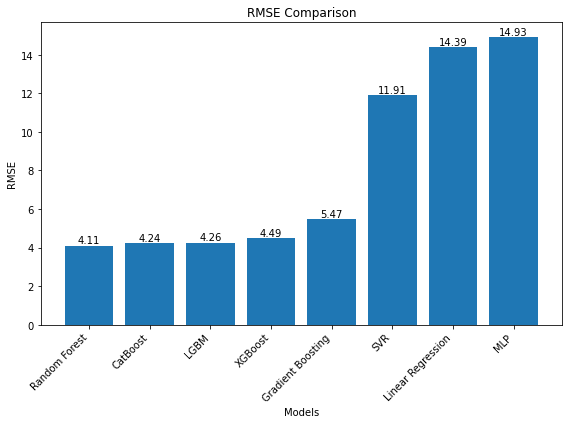

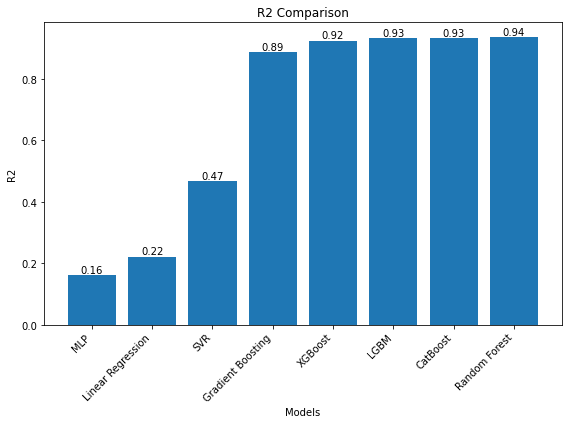

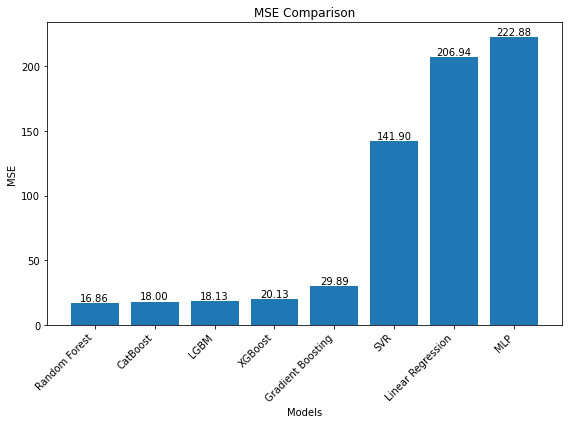

In [29]:
# Step 4: Plot bar charts for each metric
metrics_to_plot = list(eval_metrics.keys())

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 6))
    sorted_results = results_df.sort_values(metric, ascending=True)
    bars = plt.bar(sorted_results["Model"], sorted_results[metric])
    plt.xlabel("Models")
    plt.ylabel(metric)
    plt.title(f"{metric} Comparison")
    plt.xticks(rotation=45, ha='right')
    
    # Annotate the bars with their corresponding metric values
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., height, f"{height:.2f}",
                 ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


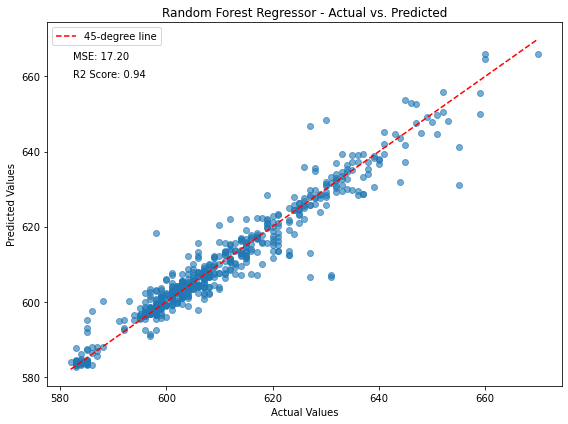

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have the data loaded in 'data' and the labels in 'target'

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Step 2: Build the Random Forest regression model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Step 4: Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 5: Create a scatter plot of actual vs. predicted values with a reference line
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='45-degree line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regressor - Actual vs. Predicted')
plt.text(0.05, 0.9, f'MSE: {mse:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f'R2 Score: {r2:.2f}', transform=plt.gca().transAxes)
plt.legend()
plt.tight_layout()
# Save the plot as an image
plt.savefig('Random Forest CO2 ActualvsPredicted.png', bbox_inches='tight')
plt.show()


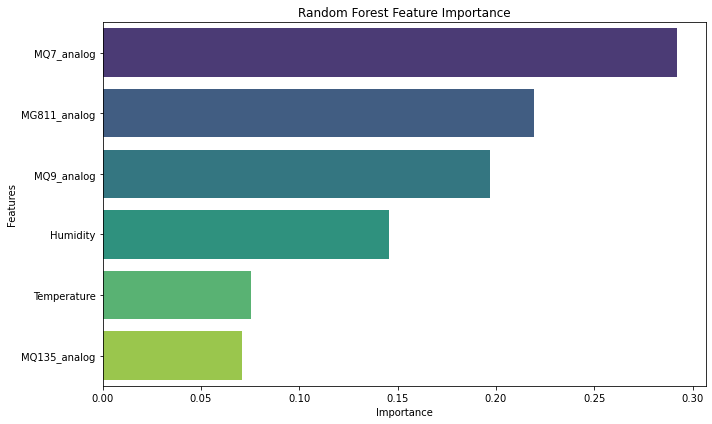

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Assuming you have the data loaded in 'data' and the labels in 'target'

# Step 1: Build the Random Forest regression model
rf_model = RandomForestRegressor()
rf_model.fit(data, target)

# Step 2: Get feature importances
feature_importance = rf_model.feature_importances_

# Step 3: Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': data.columns, 'Importance': feature_importance})

# Step 4: Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Step 5: Plot the feature importance as a bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()


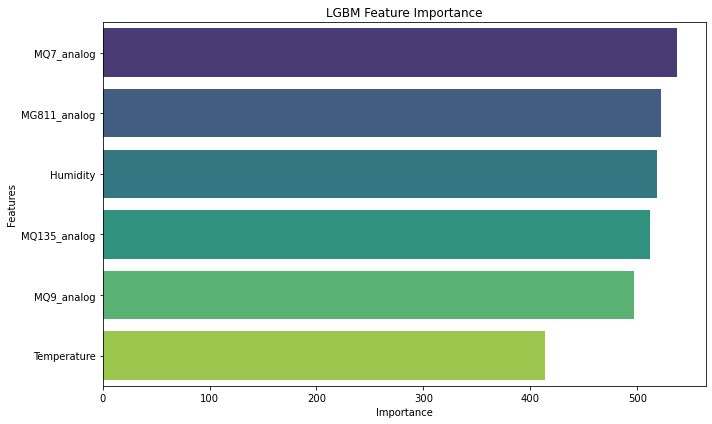

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# Assuming you have the data loaded in 'data' and the labels in 'target'

# Step 1: Build the LGBM regression model
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(data, target)

# Step 2: Get feature importances
feature_importance = lgb_model.feature_importances_

# Step 3: Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': data.columns, 'Importance': feature_importance})

# Step 4: Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Step 5: Plot the feature importance as a bar chart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('LGBM Feature Importance')
plt.tight_layout()
plt.show()


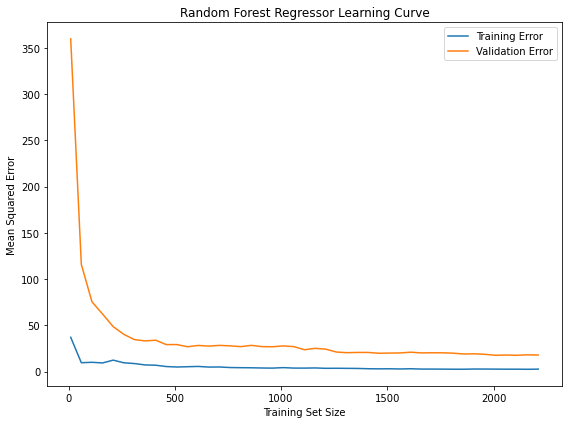

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming you have the data loaded in 'data' and the labels in 'target'

# Step 1: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Step 2: Initialize the Random Forest regression model
rf_model = RandomForestRegressor()

# Step 3: Create lists to store training and validation errors
train_errors, val_errors = [], []

# Step 4: Vary the size of the training set and compute errors
min_samples = 10  # Minimum size of the training set
step_size = 50    # Increase the training set size by this step

for i in range(min_samples, len(X_train), step_size):
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=i, random_state=42)
    
    rf_model.fit(X_train_subset, y_train_subset)
    
    # Calculate training and validation errors
    y_train_pred = rf_model.predict(X_train_subset)
    y_val_pred = rf_model.predict(X_test)
    
    train_error = mean_squared_error(y_train_subset, y_train_pred)
    val_error = mean_squared_error(y_test, y_val_pred)
    
    train_errors.append(train_error)
    val_errors.append(val_error)

# Step 5: Plot the learning curve
plt.figure(figsize=(8, 6))
plt.plot(range(min_samples, len(X_train), step_size), train_errors, label='Training Error')
plt.plot(range(min_samples, len(X_train), step_size), val_errors, label='Validation Error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Random Forest Regressor Learning Curve')
plt.legend()
plt.tight_layout()
plt.savefig('Random Forest Regressor Learning Curve.png', bbox_inches='tight')
plt.show()


In [34]:
import joblib
import lightgbm as lgb
import catboost as cb
from sklearn.ensemble import RandomForestRegressor

# Assuming you have the data loaded in 'data' and the labels in 'target'

# Step 1: Train the models
rf_model = RandomForestRegressor()
rf_model.fit(data, target)

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(data, target)

catboost_model = cb.CatBoostRegressor(silent=True, n_estimators=100)
catboost_model.fit(data, target)

# Step 2: Save the models to files using joblib, LightGBM's save_model(), and CatBoost's save_model()
rf_model_filename = 'random_forest_model.pkl'
lgb_model_filename = 'lgb_model.pkl'
catboost_model_filename = 'catboost_model.pkl'

joblib.dump(rf_model, rf_model_filename)
joblib.dump(lgb_model,lgb_model_filename)  # Corrected line for saving LightGBM model
joblib.dump(catboost_model,catboost_model_filename)


['catboost_model.pkl']

In [35]:
import pickle
catboost_model = pickle.dump(model, open("catboost_model.pkl", 'wb')) #Saving the model

In [36]:
import joblib

# Step 3: Load the saved model from the file
rf_model = joblib.load('random_forest_model.pkl')
lgb_model = joblib.load('lgb_model.pkl')
catboost_model = joblib.load('catboost_model.pkl')

In [37]:
sample = {
"raw_values":[
    {
        "Temperature":32.47,
        "Humidity":59.26,
        "MQ7_analog":2867.0,
        "MQ9_analog":1539.0,
        "MG811_analog":4654.0,
        "MQ135_analog":2564.0,
    }
        ]
}

In [38]:
data = pd.DataFrame(sample["raw_values"])
import json

In [39]:
print("Random Forest Model",json.dumps(rf_model.predict(data).tolist()[0]))
print("Light GBM Model",json.dumps(lgb_model.predict(data).tolist()[0]))
print("Catboost Model",json.dumps(catboost_model.predict(data).tolist()[0]))

Random Forest Model 610.47
Light GBM Model 611.4691488047437
Catboost Model 673795.0250278525
